In [1]:
import numpy as np
import pandas
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib

# MP expenses

This dataset is from [http://www.theipsa.org.uk/mp-costs/your-mp/](http://www.theipsa.org.uk/mp-costs/your-mp/). Code for retrieving the dataset is given at the bottom.

In [2]:
url = 'https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/mpexpenses_2018_office.csv'
mpexpenses = pandas.read_csv(url)['Amount Claimed'].values
# We'll be trying to model log(amount claimed). There are some claims <= 0,
# which certainly merit understanding, but that's not the point of this exercise.
mpexpenses = mpexpenses[mpexpenses>0]

## 1. Initial exploration

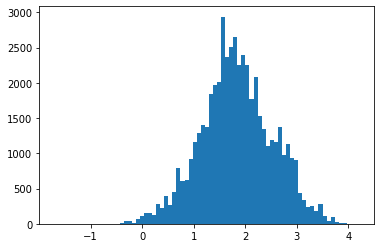

In [3]:
fig,ax = plt.subplots()
ax.hist(np.log10(mpexpenses), bins=75)
plt.show()

In [4]:
# A fitted probability model

def rx(p=0.966, μ1=1.797, μ2=2.861, σ1=0.679, σ2=0.116):
    # let k='a' with probability p, 'b' with probability 1-p
    k = np.random.choice(['a','b'], p=[p,1-p])
    if k == 'a':
        y = np.random.normal(loc=μ1, scale=σ1)
    else:
        y = np.random.normal(loc=μ2, scale=σ2)
    return np.power(10, y)

xsample = [rx() for _ in range(len(mpexpenses))]

In [5]:
# A vectorized version of the same probability model
# (Exercise: modify the code to accept μ,σ as arrays)

def rx(size=1, p=0.966, μ1=1.797, μ2=2.861, σ1=0.679, σ2=0.116):
    k = np.random.choice([1,2], p=[p,1-p], size=size)
    loc = np.where(k==1, μ1, μ2)
    scale = np.where(k==1, σ1, σ2)
    return np.power(10, np.random.normal(loc=loc, scale=scale))

xsample = rx(len(mpexpenses))

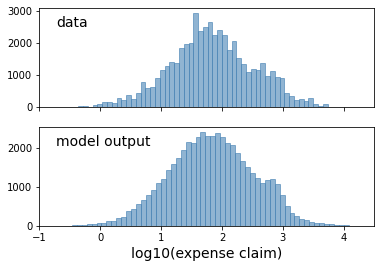

In [6]:
# Histogram of raw data, and of a synthetic sample from the probability model

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(6,4), sharex='col')
ax1.hist(np.log10(mpexpenses), bins=75, alpha=.6, fc='steelblue', ec='steelblue')
ax2.hist(np.log10(xsample), bins=75, alpha=.6, fc='steelblue', ec='steelblue')
ax1.set_title('data', x=.05, y=.75, fontsize=14, ha='left')
ax2.set_title('model output', x=.05, y=.75, fontsize=14, ha='left')
ax1.set_xlim([-1,4.5])
ax2.set_xlabel('log10(expense claim)', fontsize=14)
plt.show()

## 1.6 Fitting a generative model

In [7]:
φ = scipy.stats.norm.pdf

def logPr(y, θ):
    q,μ1,μ2,τ1,τ2 = θ
    p = np.exp(q) / (1 + np.exp(q))
    σ1,σ2 = np.exp([τ1,τ2])
    lik = p*φ(y, loc=μ1, scale=σ1) + (1-p)*φ(y, loc=μ2, scale=σ2)
    return np.log(lik)

y = np.log10(mpexpenses)
initial_guess = [1, 1.8,2.7, np.log(1.2),np.log(0.5)] # from eyeballing the histogram
θhat = scipy.optimize.fmin(lambda θ: -np.sum(logPr(y,θ)), initial_guess, maxiter=5000)

Optimization terminated successfully.
         Current function value: 53774.555345
         Iterations: 573
         Function evaluations: 900


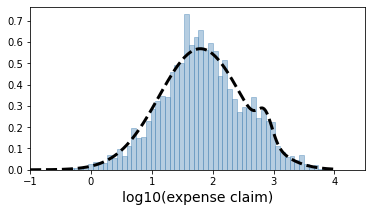

In [8]:
# Density histogram of the data,
# and fitted probability density function

y = np.linspace(-1,4,200)
lik = np.exp(logPr(y,θhat))

fig,ax = plt.subplots(figsize=(6,3))
ax.hist(np.log10(mpexpenses), bins=75, density=True, alpha=.4, fc='steelblue', ec='steelblue')
ax.plot(y, lik, c='black', linestyle='dashed', linewidth=3)
ax.set_xlim([-1,4.5])
ax.set_xlabel('log10(expense claim)', fontsize=14)
plt.show()

## Appendix: scraping the dataset

In [3]:
import requests
import requests_cache
import lxml.html
import urllib.parse
import re
import io
import IPython.display
import pandas
requests_cache.install_cache('mp', backend='memory')

In [4]:
URL = 'http://www.theipsa.org.uk/mp-costs/your-mp/'
resp = requests.get(URL)
doc = lxml.html.fromstring(resp.content)

In [ ]:
mps = doc.xpath('//*[@class="mp-letter"]/ul/li/a')
mps = pandas.DataFrame.from_records([(mp.text, mp.get('href')) for mp in mps], columns=['name','url'])
print("MPs with no url\n", mps.loc[mps['url'] == ''])
mps = mps.loc[mps['url'] != '']

In [ ]:
res = []
for i, (mp_name, url) in enumerate(zip(mps['name'], mps['url'])):
    IPython.display.clear_output(wait=True)
    print(f"{i+1}/{len(mps)}: {mp_name}")

    resp = requests.get(urllib.parse.urljoin(URL, url))
    doc = lxml.html.fromstring(resp.content)

    s = doc.xpath("//script[contains(text(),'downloadclaimscsvformp')]")[0].text
    download = re.search(r'window.open\("(?P<url>/download/downloadclaimscsvformp/(?P<id>.+))"\)', s)
    resp = requests.get(urllib.parse.urljoin(URL, download['url']))

    res.append((download['id'], pandas.read_csv(io.BytesIO(resp.content))))

In [7]:
df = []
for mp_id, mp_df in res:
    mp_cleandf = mp_df.loc[~pandas.isnull(mp_df['Claim No.'])].copy(deep=False)
    mp_cleandf['mp_id'] = mp_id
    df.append(mp_cleandf)
df = pandas.concat(df)

In [8]:
df.to_csv('mpexpenses.csv', index=False)

In [12]:
df2 = df.loc[(df.Year=='18_19') & (df.Category=='Office Costs'),
             ['Date','Claim No.',"MP's Name", "MP's Constituency", "Category", "Expense Type", "Short Description",
              "Details","Amount Claimed", "Amount Paid","Amount Not Paid","Amount Repaid","Status",'mp_id',"Reason If Not Paid"]]

df2 = pandas.concat([df2.loc[~pandas.isna(df2['Reason If Not Paid'])], df2.loc[pandas.isna(df2['Reason If Not Paid'])]])
df2.to_csv('mpexpenses_2018_office.csv', index=False)